# SOCIB Modelling and Forecasting Facility - MFF Python Library Tutorials
## Calculating FSLE (Finity-Size Lyapunov Exponent)
### Using [OceanParcels](https://oceanparcels.org) to simulate the particles necessary to calculate the FSLE.
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../')

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### **Importing the MFF modules**

In [4]:
from socib_modelling_python.batch import SimulationFactory
from socib_modelling_python.compute import lagrangian as mff_lagrangian
from socib_modelling_python.plot.mff_maps import plot_points_map

INFO: Compiled ParcelsRandom ==> /tmp/parcels-19211/libparcels_random_da32d109-4735-4dcd-b491-3d4fbc8547fc.so


In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean

In [6]:
import cartopy
import cartopy.feature as cfeature

land_map = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

#### **Loading some data**

In [7]:
data = xr.open_dataset("/LOCALDATA/Alex/sandbox/wmop_surface_thredds.nc", chunks='auto')

<Figure size 432x288 with 0 Axes>

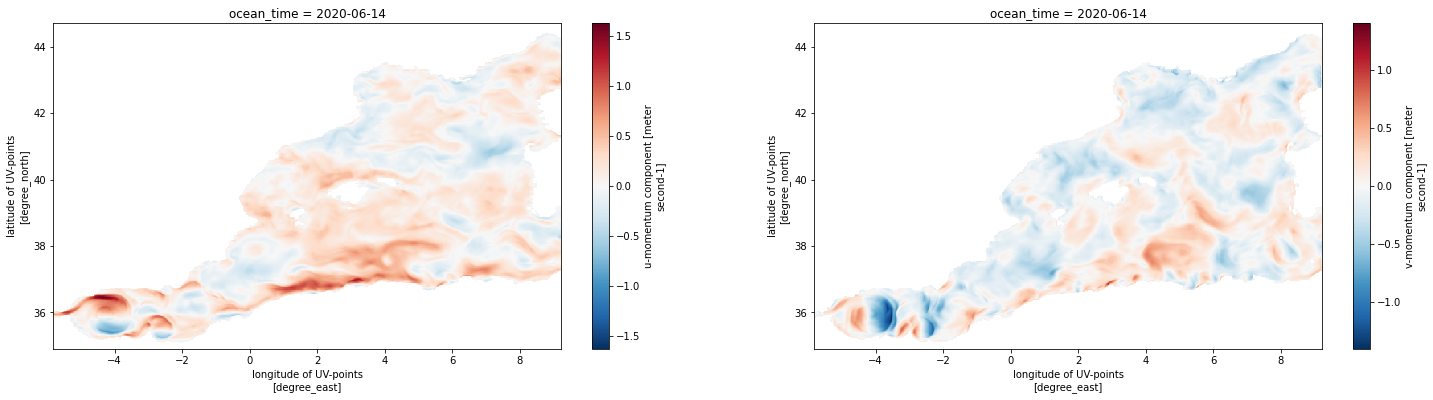

In [8]:
fig = plt.figure()
fig, axes = plt.subplots(1, 2, figsize=(25,6))
plt.sca(axes[0])
data.isel(ocean_time=0).squeeze().u.plot()
plt.sca(axes[1])
data.isel(ocean_time=0).squeeze().v.plot()
plt.show()

#### **Generating particles on grid points**

setting a land_mask

In [9]:
da = data['u'].isel(ocean_time=0)
land = np.isnan(da)
data['land_mask'] = land

land_coords = {
    'latitude': 'lat_uv',
    'longitude': 'lon_uv'
}

#### **Setting-up the simulator**
we first define a list of kernels in the order to be executed, for that examples we used only the Advection (2D) kernel.  
Then we initizalize our simulator passing a list of particles and other parameters.  
For this exemple, we activated the periodic boundary strategy for 'DeleteParticles'.  

For FSLE experiments it is necessary to indicate that particles has associations.  
The association's parameters can be past thru a dictionary named "associatio" inside the particles specification.  
The simulation factory will call the method `associate_particles` from `GenerateParticles` class.  
This method creates N new particles for each existent particle.  
Then, the method updates the set of particles generated by the main method (e.g: from_grid) and saves all this information, including the new associations, in a NetCDF file.  
This NetCDF file is necessary to calculate the FSLE.

In [10]:
specs = {
    "kind": "parcels",
    "fieldset": {
        "params": {
            "field": data,
            "variables": {"U": "u", "V": "v"},
            "dimensions": {"time": "ocean_time",
                           "lat": "lat_uv", "lon": "lon_uv"},
        }
    },
    "particles": {
        "generator": {
            "method": "from_grid",
            "params": {
                "grid": data,
                "latitude": 'lat_uv',
                "longitude": 'lon_uv',
                "land_mask": data["land_mask"],
                "land_mask_coords": land_coords,
                "region": "BalearicIslands"
            },
            "association": {
                "n_associations": 4,
                "distance": 2_000,
                "land_mask": data["land_mask"],
                "land_mask_coords": land_coords,
                "filename_associations": "/tmp/associations_tutorial_calculate_fsle_with_parcels.nc"
            }
        },
        "pclass": "JITParticle"
    },
    "kernels": {
        "sequence": ["AdvectionRK4"]
    },
    "strategies": {
        "boundaries": "DeleteParticle"
    },
    "execution": {
        "dt": {"hours": 3},
        "outputdt": {"days": 1},
        "runtime": {"days": 200}
    }
}

#### **Building the simulator with the configuration dictionary and the information about Particles Association.**  

In [11]:
simulation = SimulationFactory.produce(specs)
generated_particles = simulation.get_all_particles_location()

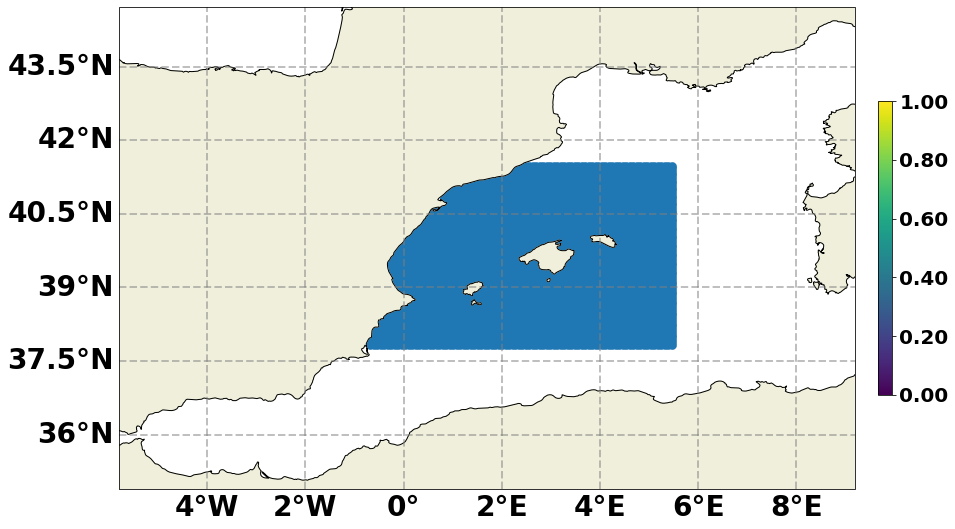

In [12]:
plot_points_map(generated_particles[1], generated_particles[0], show=True, region='WesternMed', kind='scatter', marker_size=10)

#### **Running the simulation**
The method "run" accepts a file location where the output will be written.  
Otherwise, a temporary file will be create and the file location is the return value of "run".

In [13]:
output_file = simulation.run(output_filename="/tmp/tutorial_calculate_fsle_with_parcels.nc")

100% (17280000.0 of 17280000.0) |########| Elapsed Time: 0:03:09 Time:  0:03:09


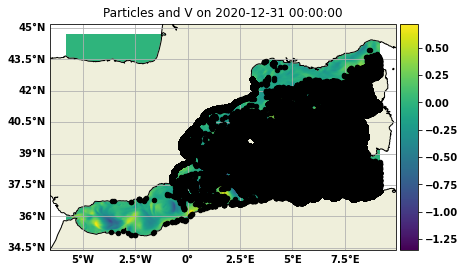

In [14]:
simulation.particle_set.show(field=simulation.field.V, land='10m', cartopy_features=[land_map])

### Calculating FSLE with the simulation output

In [15]:
output_file = "/tmp/tutorial_calculate_fsle_with_parcels.nc"
association_file = "/tmp/associations_tutorial_calculate_fsle_with_parcels.nc"

In [16]:
simulation_result = xr.open_dataset(output_file)

In [17]:
simulation_association = xr.open_dataset(association_file)

In [30]:
fsle_result = mff_lagrangian.calculate_FSLE(output_file, association_file, delta_i=2_000, delta_f=40_000, delta_t=1)

100%|██████████| 43009/43009 [00:08<00:00, 4816.93it/s]


In [19]:
plat = simulation_association.particles.values[:,0]
plon = simulation_association.particles.values[:,1]

In [20]:
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import cartopy.geodesic as geodesic
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [21]:
from socib_modelling_python.config import Config as MFF_Config
_MFF_CONFIG = MFF_Config()

In [22]:
fsle_grid = np.ones((data.dims['lat_uv'], data.dims['lon_uv'])) * np.nan

In [31]:
for pi, pj, v in zip(plat, plon, fsle_result):
    idx_lon = (np.abs(data.lon_uv.values - pj)).argmin()
    idx_lat = (np.abs(data.lat_uv.values - pi)).argmin()
    fsle_grid[idx_lat, idx_lon] = v

In [24]:
region='BalearicIslands'
cfg = _MFF_CONFIG.get('regions')[region]

In [25]:
ones = np.ones((data.dims['lat_uv'], data.dims['lon_uv']))

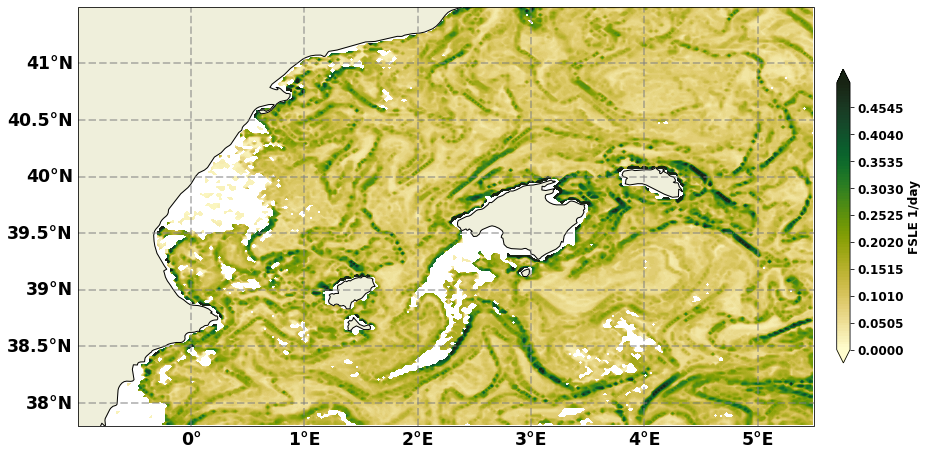

In [32]:
map_min_lon, map_max_lon, map_min_lat, map_max_lat = cfg['area']
fig = plt.figure(**cfg['figure'])
ax = plt.axes(projection=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                    edgecolor='face',
                                    facecolor=cfeature.COLORS['land'])
ax.add_feature(land)
ax.coastlines(resolution='10m')
ax.set_extent([map_min_lon, map_max_lon, map_min_lat, map_max_lat], crs=ccrs.PlateCarree())

vmin = 0.0
vmax = 0.5

levels = np.linspace(vmin, vmax, 100)

cs = plt.contourf(data.lon_uv.values, data.lat_uv.values, fsle_grid,
                  vmin=vmin, vmax=vmax, levels=levels, extend='both', cmap=cmocean.cm.speed)

cb = plt.colorbar(cs, orientation='vertical', pad=0.025, shrink=0.6)
cb.set_label("FSLE 1/day", size='large', weight='bold')
cb.ax.tick_params(labelsize='large')

# gridlines formatting
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
if 'xgridlines' in cfg:
    gl.xlocator = mticker.FixedLocator(cfg['xgridlines'])
if 'ygridlines' in cfg:
    gl.ylocator = mticker.FixedLocator(cfg['ygridlines'])
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'color': 'k', 'weight': 'bold', 'size': 'xx-large'}
gl.ylabel_style = {'color': 'k', 'weight': 'bold', 'size': 'xx-large'}

plt.show()

---
---
---
---
---
---
---
---
---
---